In [1]:
#imports
import numpy as np
from collections import deque
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt

In [2]:

ratio_train_test = 0.9
np.random.seed(0)
plt.rcParams["figure.figsize"] = (45,20)

In [3]:
############################################################################################
################################ STEP 1: Loading Data ######################################
############################################################################################
#clean
data_clean = np.loadtxt("wifi_db/clean_dataset.txt")
print(data_clean.shape)
np.random.shuffle(data_clean)

#noisy
data_noisy = np.loadtxt("wifi_db/noisy_dataset.txt")
print(data_noisy.shape)
np.random.shuffle(data_noisy)

(2000, 8)
(2000, 8)


In [4]:
#############################################################################################
############################## STEP 2: Creating Decision Tree ###############################
#############################################################################################

class Node:
    """Will hold data of the DecisionTree"""
    def __init__(self, feature, split_value, l_child=None, r_child=None):
        self.feature = feature #label for splitting or "leaf"
        self.split_value = split_value #the split value is the label if the node is a "leaf"
        self.l_child = l_child
        self.r_child = r_child
        
    def modify_attributs(self, new_child):
        self.feature = new_child.feature
        self.split_value = new_child.split_value
        self.r_child = new_child.r_child
        self.l_child = new_child.l_child
    
    def __str__(self):
        return "[Node] Feature: {} Split Value: {}".format(self.feature, self.split_value)
    
def compute_entropy(data):
    """Compute the entropy """
    if len(data) == 0:
        return 0
    entropy = 0
    for i in range(1, 5):
        #empirical frequency
        nb_samples_i = len(data[data[:,-1] == i])
        if nb_samples_i == 0:
            continue
        p = nb_samples_i / len(data)
        #Shannon
        entropy += p*np.log2(p)
    return -entropy

    
    
def compute_information_gain(data, subset_left, subset_right):
    """Return the information gain for one particular split"""
    entropy_data = compute_entropy(data)
    entropy_left = compute_entropy(subset_left)
    entropy_right = compute_entropy(subset_right)
    return entropy_data - ((len(subset_left)/len(data))*entropy_left + (len(subset_right)/len(data))*entropy_right)

def find_split(data):
    """Check all possible splits of the data and select the best one wrt information gain"""
    feature = None
    split_value = None
    l_data = None
    r_data = None
    max_information_gain = 0
    information_gain = 0
    for i in range(len(data[0])-1):#goes through all features
        data = data[data[:,i].argsort()]#sort data wrt this feature
        for j in range (1, len(data)):#goes through all data 
            if data[j][-1] != data[j-1][-1]:#the samples have different label
                potential_split = (data[j][i] + data[j-1][i]) / 2
                #subset creation with this split value
                subset_left = data[data[:,i] <= potential_split,:]
                subset_right = data[data[:,i] > potential_split,:]
                information_gain = compute_information_gain(data, subset_left, subset_right)
                if information_gain > max_information_gain:
                    max_information_gain = information_gain
                    feature = i
                    split_value = potential_split
                    l_data = subset_left
                    r_data = subset_right
            
    return l_data, r_data, split_value, feature

def decision_tree_learning(data, depth=0):
    """Build the DecisionTree with no depth limit (probably overfitting on training data)
       and return the tree and its depth"""
    if len(np.unique(data[:,-1])) == 1:#every sample belongs to the same label
        return (Node("leaf", data[0][-1]) , depth)
    
    l_data, r_data, split_value, feature = find_split(data)
    new_node = Node(feature, split_value)
    l_node, l_depth = decision_tree_learning(l_data, depth+1)
    r_node, r_depth = decision_tree_learning(r_data, depth+1)
    new_node.l_child = l_node
    new_node.r_child = r_node
    return (new_node, max(l_depth, r_depth))




In [5]:
#############################################################################################
################################# STEP 2: Bonus visualization ###############################
#############################################################################################

def plot_tree(tree, max_depth=None):
    """Plot the tree. If max_depth is None, plot the whole tree, 
    otherwise plot tree until max_depth is reached"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.axis('off')

    ##array that gets continuously filled with all nodes left to visit
    node_to_visit = deque([tree])
    depth = 0 #used to keep track of the depth
    const = 0
    first = 0 #the first node needs a different coordinate calculation

    while len(node_to_visit) != 0: #goes through all the "layers" of the tree

        #check if there is no more nodes left to visit
        if node_to_visit.count(None) == len(node_to_visit):
            break

        #goes through all the nodes in a given layer (depth)
        for i in range(len(node_to_visit)):
            current_node = node_to_visit.popleft()

            #Nones are used to keep track of the correct location of a node
            if current_node is None:
                node_to_visit.append(None)
                node_to_visit.append(None)
                continue

            node_to_visit.append(current_node.l_child)
            node_to_visit.append(current_node.r_child)

            if current_node.feature != "leaf":
                st = "X{} < {}".format(current_node.feature, current_node.split_value)
                bbox_props = dict(boxstyle="round,pad=1", fc="white", ec="black", lw=1)

                #calculaing the relative position of the node within the layer
                if((i - 2**(depth-1)) < 0):
                    const = i - 2**(depth-1)
                else:
                    const = i - 2**(depth-1) + 1

                #The relative position gets transformed into 2*x-1 to produce accurate calculations of horizontal location
                if const > 0:
                    const = const*2-1
                else:
                    const = const*2+1

                #Drawing arrows from current node to future children nodes
                ax.arrow(0.5 + first * const * (0.5/(2**depth)), 1-0.04*depth, -(0.25/(2**depth)), -0.04, head_width=0.0001, head_length=0.0001, color = 'green')
                ax.arrow(0.5 + first * const * (0.5/(2**depth)), 1-0.04*depth, (0.25/(2**depth)), -0.04, head_width=0.0001, head_length=0.0001, color = 'red')

                #Drawing text box for current node
                t = ax.text(0.5 + first * const * (0.5/(2**depth)), 1-0.04*depth, st, ha="center", va="center", rotation=0,
                        size=30,
                        bbox=bbox_props)
                bb = t.get_bbox_patch()
                bb.set_boxstyle("round", pad=0.1)
                first = 1 #only matters in the first iteration when first = 0

            #Same as above but with different text and no arrows as this is a leaf
            else:
                st = "LEAF: {}".format(int(current_node.split_value))
                bbox_props = dict(boxstyle="round,pad=1", fc="white", ec="black", lw=1)
                if((i - 2**(depth-1)) < 0):
                    const = i - 2**(depth-1)
                else:
                    const = i - 2**(depth-1) + 1

                if const > 0:
                    const = const*2-1
                else:
                    const = const*2+1

                t = ax.text(0.5 + first * const * (0.5/(2**depth)), 1-0.04*depth, st, ha="center", va="center", rotation=0,
                        size=30,
                        bbox=bbox_props)
                bb = t.get_bbox_patch()
                bb.set_boxstyle("round", pad=0.5)
        depth += 1 #keeping track of the layers
        if max_depth and depth > max_depth:
            break

In [6]:
################################################################################################
#################################### STEP 3: EVALUATION ########################################
################################################################################################


def predict_sample(tree, sample_x):
    """Pass the sample through the DecisionTree and return its prediction"""
    while True:
        feature = tree.feature
        if feature == "leaf":
            return tree.split_value #it is not really the split value but the prediction..
        if sample_x[feature] <= tree.split_value:
            tree = tree.l_child
        else:
            tree = tree.r_child
        

def predict(tree, data_x):
    """Return a vector of predictions for a dataset"""
    predictions = np.zeros(len(data_x))
    for index, sample_x in enumerate(data_x):
        predictions[index] = predict_sample(tree, sample_x)
    return predictions

def create_confusion_matrix(y_true, y_pred):
    """Return the confusion matrix for the provided data"""
    confusion_matrix = np.zeros((len(np.unique(y_true)), len(np.unique(y_true))))
    for i in range(len(y_true)):
        confusion_matrix[int(y_true[i])-1][int(y_pred[i])-1] += 1 #We use the labels as indexes
    return confusion_matrix

def metrics_calculation(conf_mat):
    """Compute every metrics thanks to the confusion matrix"""
    precision = [0 for i in range(4)]
    recall = [0 for i in range(4)]
    F_1 = [0 for i in range(4)]
    total_correct = 0
    for i in range(4):
        precision[i] = conf_mat[i,i]/(np.sum(conf_mat[:,i])+0.00000001)
        recall[i] = conf_mat[i,i]/(np.sum(conf_mat[i,:])+0.00000001)
        F_1[i] = 2*precision[i]*recall[i]/((recall[i]+precision[i])+0.00000001)
        total_correct += conf_mat[i,i]
    total_accuracy = total_correct/np.sum(conf_mat)

    return total_accuracy, precision, recall, F_1

def evaluate_accuracy(tree, data):
    """Evaluate model accuracy only"""
    data_y = data[:,-1]
    data_x = data[:,:-1]
    predictions = predict(tree, data_x)
    correct = sum([1 for i in range(len(predictions)) if predictions[i]==data_y[i]])
    accuracy = correct/len(predictions)
    return accuracy

def evaluate(tree, data, display=True):
    """Evaluate model overall accuracy, accuracy per class and confusion matrix"""
    data_y = data[:,-1]
    data_x = data[:,:-1]
    predictions = predict(tree, data_x)
    confusion_matrix = create_confusion_matrix(data_y, predictions)
    acc, prec, rec, F_1 = metrics_calculation(confusion_matrix)

    if display:
        print("-------------MODEL EVALUATION-------------\n")
        print("Test Accuracy")
        print(acc)
        print()
        print("Confusion Matrix")
        print(confusion_matrix)
        print()
        print("Precision by Class")
        print("1: {}  2: {}  3: {}  4: {}  " .format(prec[0], prec[1], prec[2], prec[3]))
        print()
        print("Recall by Class")
        print("1: {}  2: {}  3: {}  4: {}  " .format(rec[0], rec[1], rec[2], rec[3]))
        print()
        print("F1 by Class")
        print("1: {}  2: {}  3: {}  4: {}  " .format(F_1[0], F_1[1], F_1[2], F_1[3]))
    return confusion_matrix

def cross_validation(data, nb_fold=10, pruning=False):
    """Compute cross_validation for the DecisionTree model"""
    fold_size = int(len(data)/nb_fold)
    overall_acc = 0
    overall_confusion_matrix = np.zeros((4,4))
    overall_acc_per_class = np.zeros(4)
    overall_depth = 0
    for i in range(nb_fold):
        data_train = np.concatenate((data[:i*fold_size], data[(i+1)*fold_size:]), axis=0) #take out a slice of data
        data_test = data[i*fold_size:(i+1)*fold_size] #select this slice
        if pruning: #we need a validation dataset
            data_validation, data_train = data_train[:len(data_test)], data_train[len(data_test):]
            tree, depth = decision_tree_learning(data_train)
            depth = prune(tree, data_validation)
        else: #we use all train data
            tree, depth = decision_tree_learning(data_train)
        confusion_matrix = evaluate(tree, data_test, False)
        overall_confusion_matrix = overall_confusion_matrix + confusion_matrix
        overall_depth += depth
    overall_depth /= nb_fold
    acc, prec, rec, F_1 = metrics_calculation(overall_confusion_matrix)
    
    print("\n----------------CROSS VALIDATION ({} folds)-----------------\n".format(nb_fold))
    print("Pruning: ", pruning)
    print("Mean depth: ", overall_depth)
    print()
    print("Overall Test Accuracy")
    print(acc)
    print()
    print("Confusion Matrix")
    print(overall_confusion_matrix)
    print()
    print("Precision by Class")
    print("1: {}  2: {}  3: {}  4: {}  " .format(prec[0], prec[1], prec[2], prec[3]))
    print()
    print("Recall by Class")
    print("1: {}  2: {}  3: {}  4: {}  " .format(rec[0], rec[1], rec[2], rec[3]))
    print()
    print("F1 by Class")
    print("1: {}  2: {}  3: {}  4: {}  " .format(F_1[0], F_1[1], F_1[2], F_1[3]))
    
        
    

Tree depth: 13
-------------MODEL EVALUATION-------------

Test Accuracy
0.97

Confusion Matrix
[[52.  0.  0.  0.]
 [ 0. 55.  3.  0.]
 [ 1.  2. 48.  0.]
 [ 0.  0.  0. 39.]]

Precision by Class
1: 0.9811320752865789  2: 0.9649122805324715  3: 0.9411764704036909  4: 0.9999999997435898  

Recall by Class
1: 0.9999999998076923  2: 0.9482758619054696  3: 0.9411764704036909  4: 0.9999999997435898  

F1 by Class
1: 0.9904761852879819  2: 0.9565217339644613  3: 0.9411764654036909  4: 0.9999999947435898  


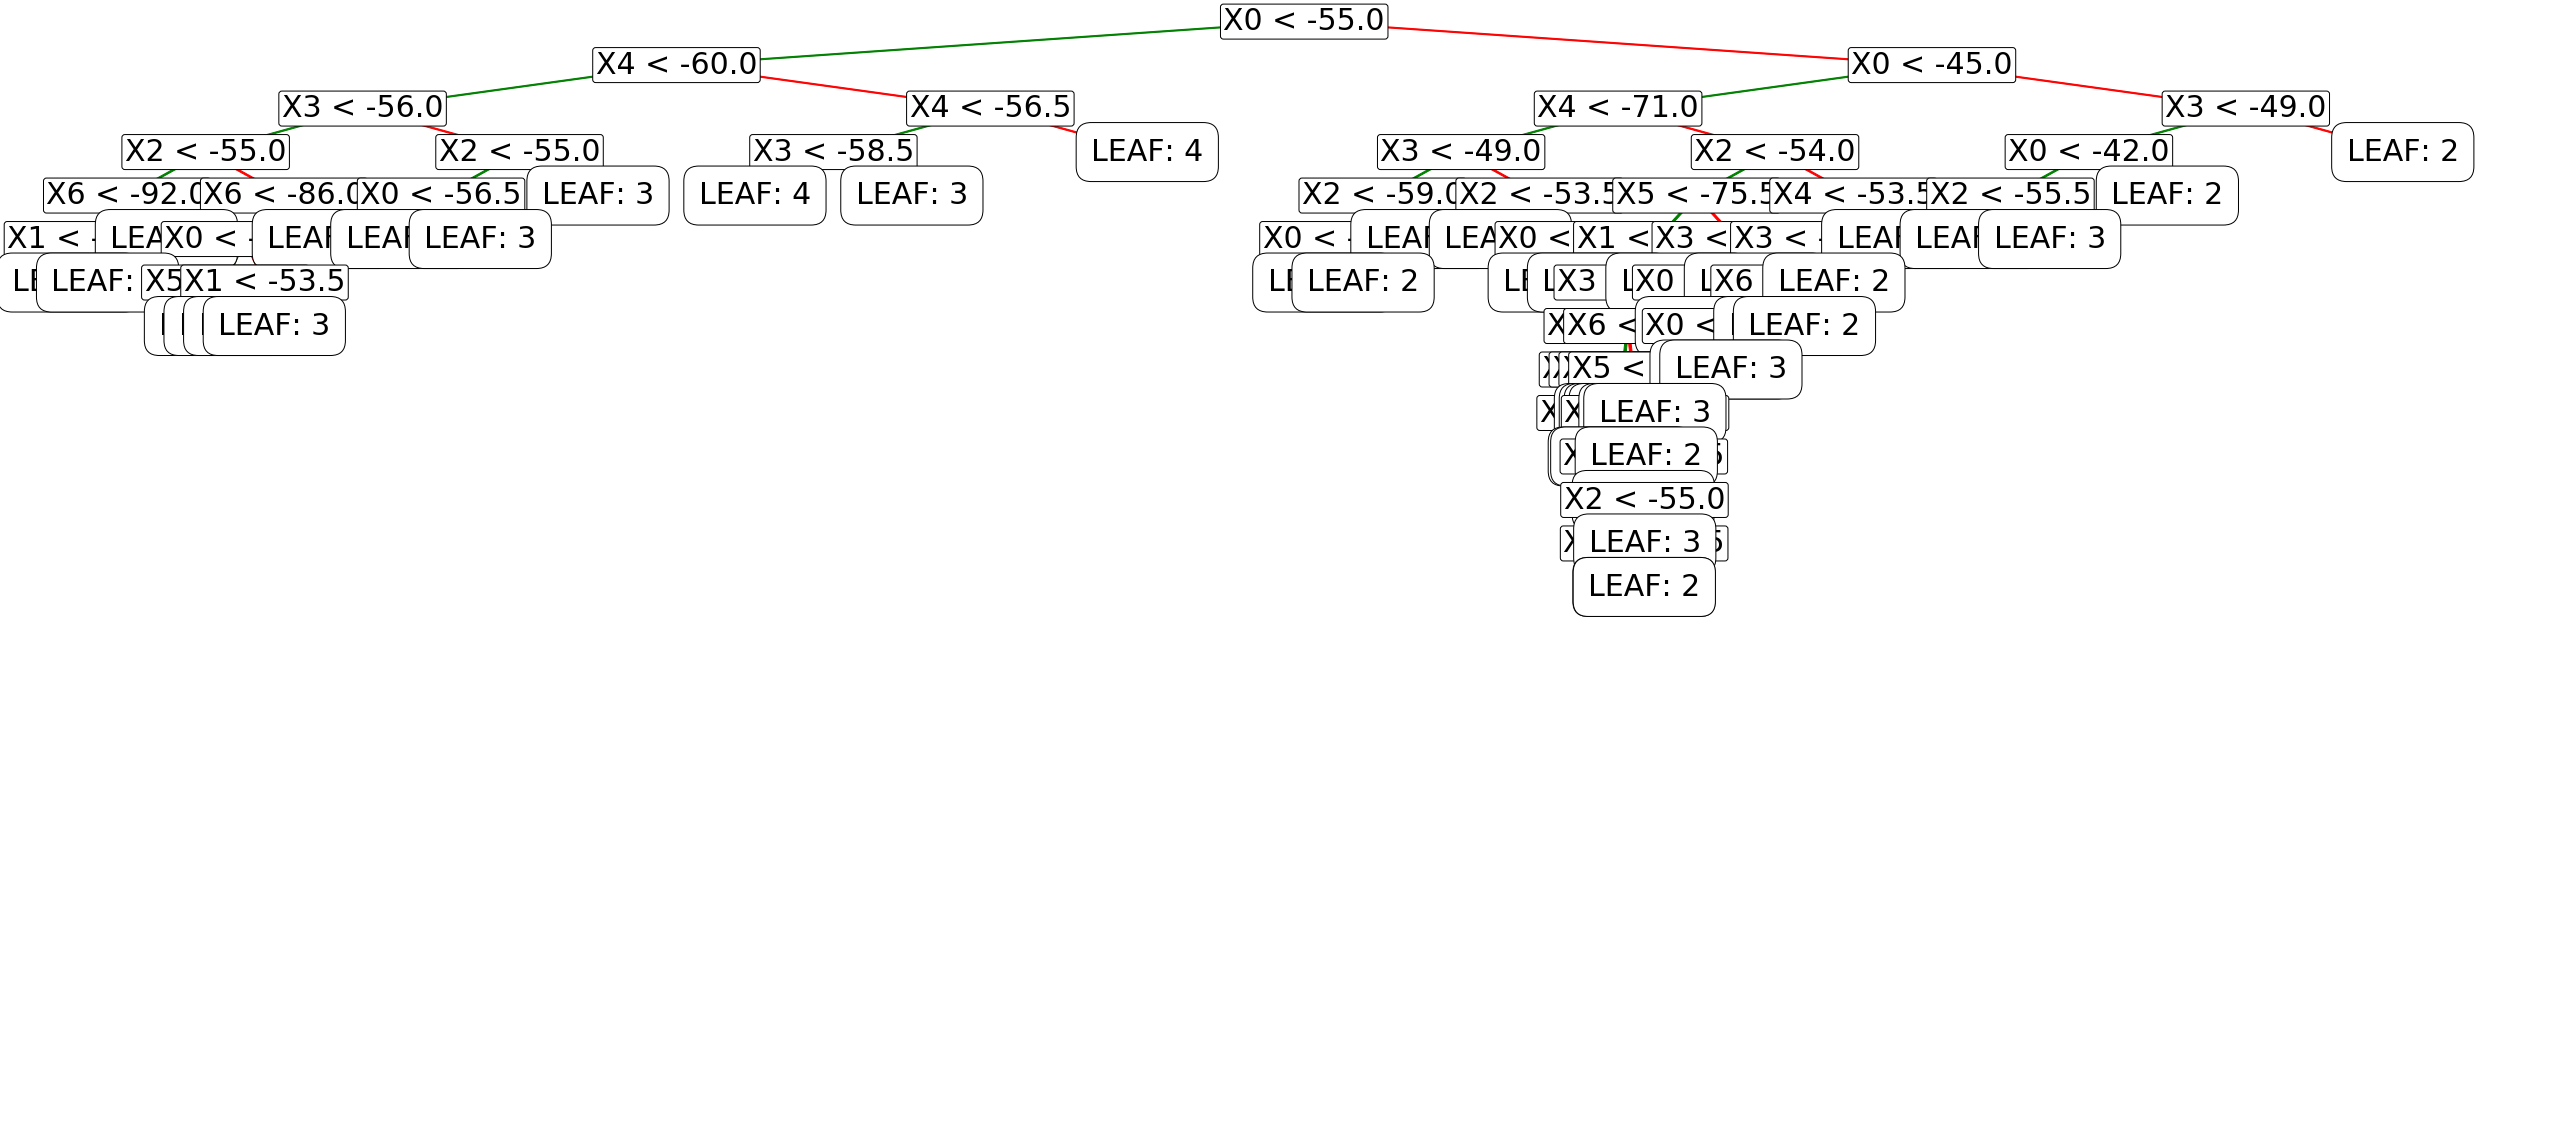

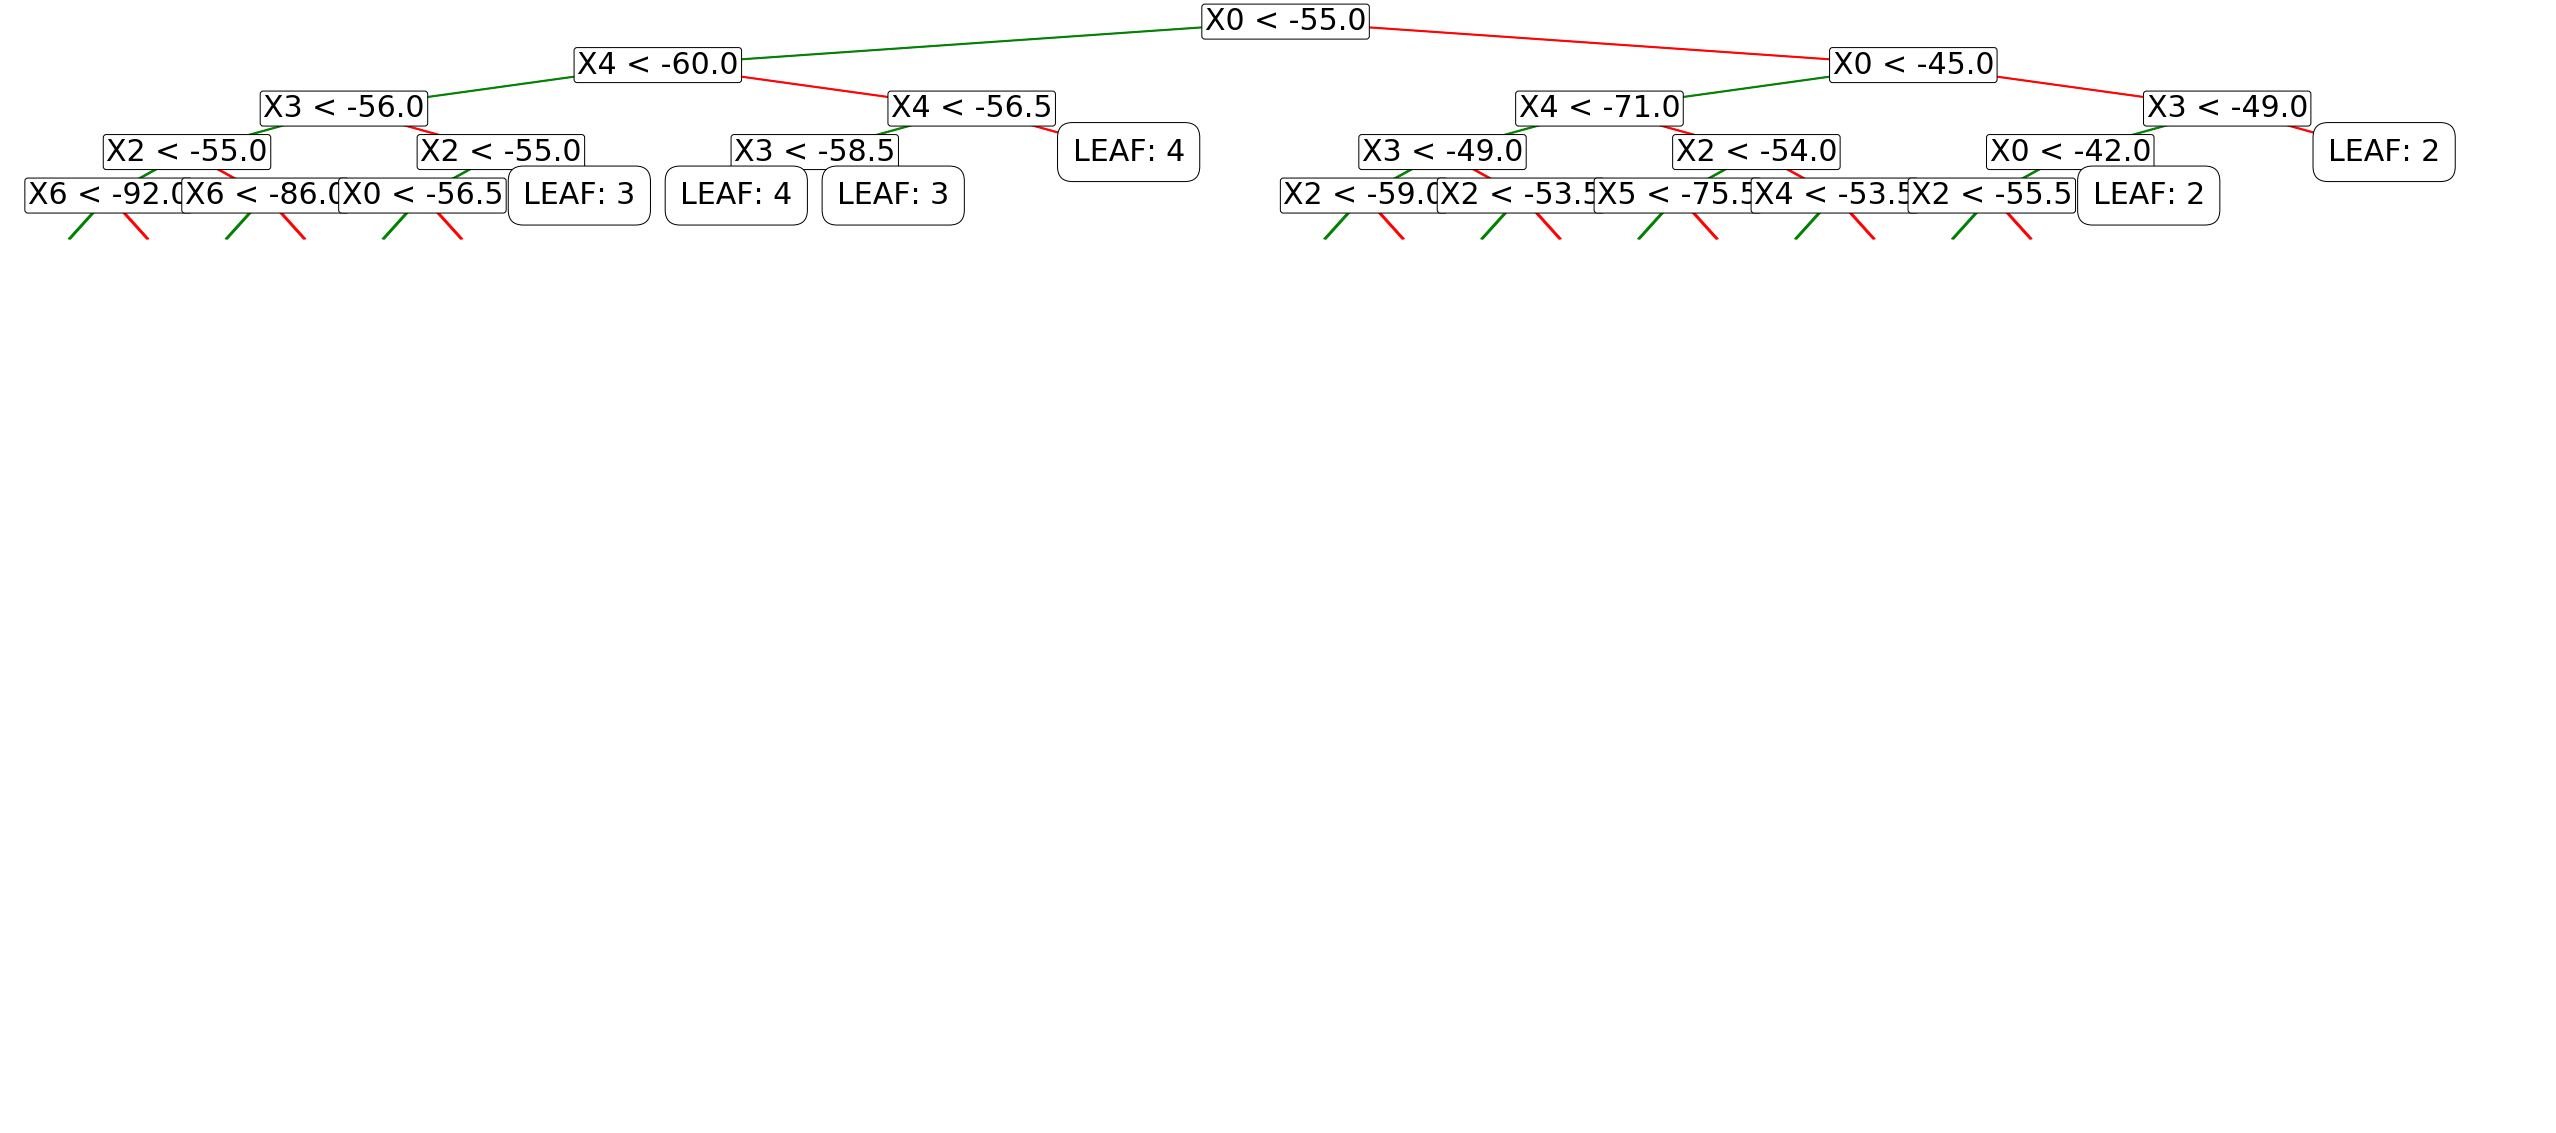

In [7]:
#Test on clean data
data_clean_train = data_clean[:int(len(data_clean)*ratio_train_test)]
data_clean_test = data_clean[int(len(data_clean)*ratio_train_test):]
tree, depth = decision_tree_learning(data_clean_train)
print("Tree depth:", depth)
ev = evaluate(tree, data_clean_test)
plot_tree(tree, max_depth=None)
plot_tree(tree, max_depth=4)



depth:  18
-------------MODEL EVALUATION-------------

Test Accuracy
0.81

Confusion Matrix
[[34.  4.  6.  3.]
 [ 3. 45.  3.  2.]
 [ 1.  2. 49.  4.]
 [ 4.  5.  1. 34.]]

Precision by Class
1: 0.8095238093310657  2: 0.8035714284279336  3: 0.830508474435507  4: 0.7906976742347215  

Recall by Class
1: 0.7234042551652331  2: 0.8490566036133855  3: 0.87499999984375  4: 0.7727272725516529  

F1 by Class
1: 0.76404493866431  2: 0.8256880682467806  3: 0.8521739078986768  4: 0.7816091902232792  


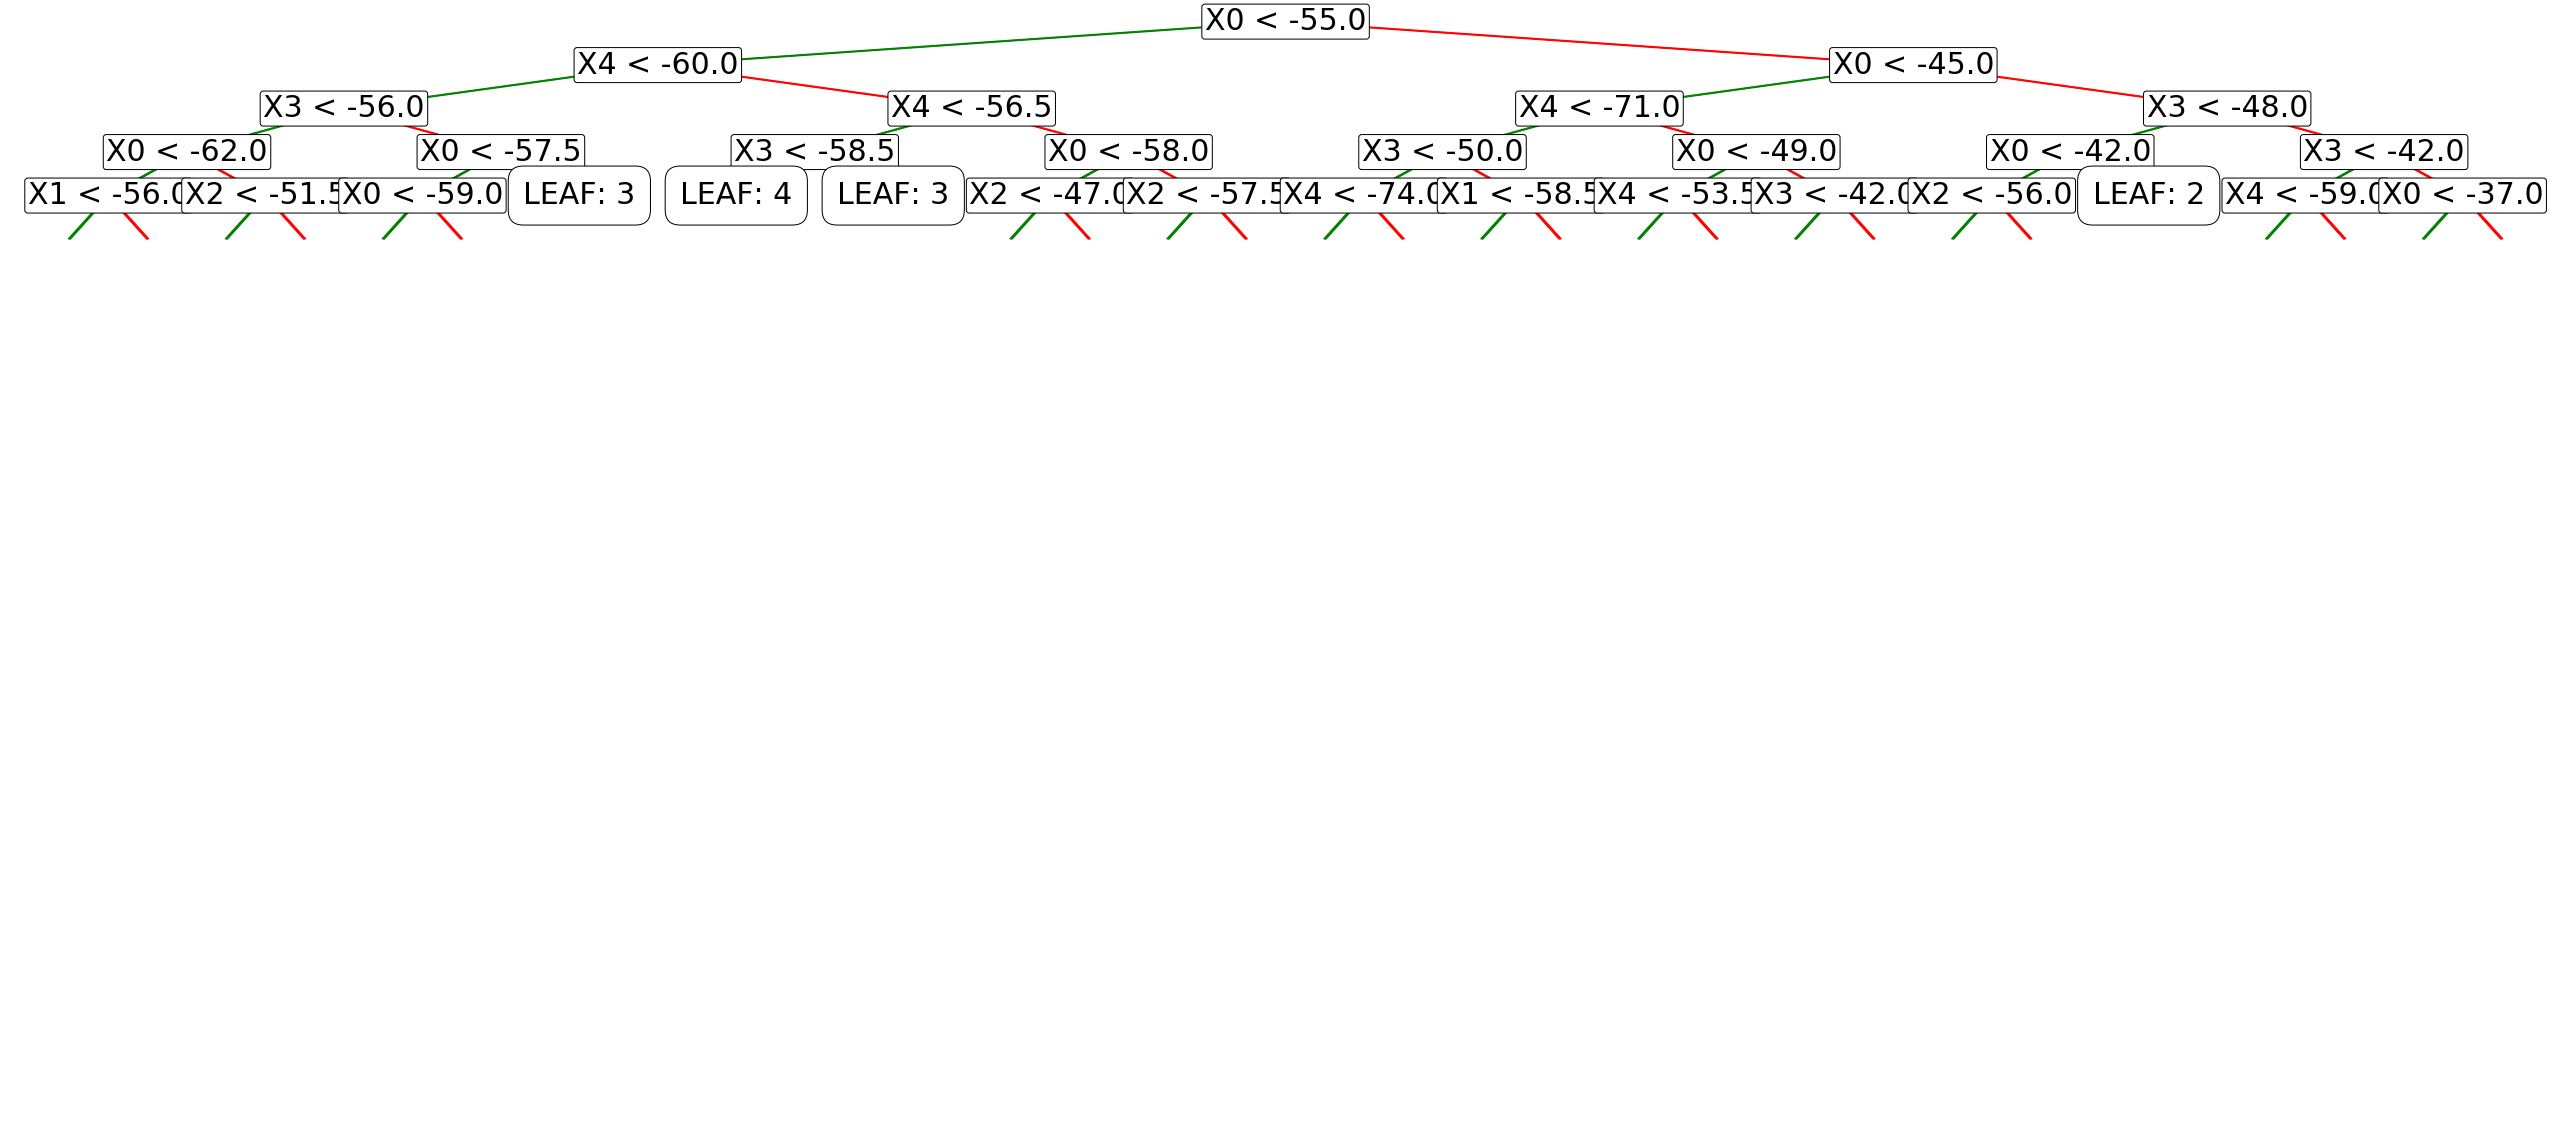

In [8]:
# Test on noisy data
data_noisy_train = data_noisy[:int(len(data_noisy)*ratio_train_test)]
data_noisy_test = data_noisy[int(len(data_noisy)*ratio_train_test):]
tree, depth = decision_tree_learning(data_noisy_train)
print("depth: ", depth)
ev = evaluate(tree, data_noisy_test)
plot_tree(tree, max_depth=4)



In [9]:
#################################################################################################
####################################### STEP 4: PRUNING #########################################
#################################################################################################

def prune(tree, data_validation):
    """Pruning function that prunes the tree as long as pruning modify the tree"""
    tree_stable = False
    while not tree_stable:
        tree_stable, depth = pruning_iteration(tree, tree, data_validation, tree_stable, 0)
    return depth

def pruning_iteration(tree, current_node, data_validation, tree_stable, depth):
    """Goes through the whole tree and try to prune the deepest non-leaf nodes"""
    if current_node is None or current_node.feature == "leaf":
        #Too deep
        return True, depth
    if current_node.l_child.feature == "leaf" and current_node.r_child.feature == "leaf":
        #Potential puning of current node
        potential_nodes = [Node("leaf", current_node.l_child.split_value), Node("leaf", current_node.r_child.split_value), current_node]
        validation_err = np.zeros(3)
        for i, node in enumerate(potential_nodes): #compute validation error of the 3 potential trees
            current_node.modify_attributs(node)
            acc = evaluate_accuracy(tree, data_validation)
            validation_err[i] = 1.0 - acc
        index = np.argmin(validation_err)#select the best tree wrt validation error
        current_node.modify_attributs(potential_nodes[index]) #modify the tree with the right node
        if index != 0:
            return False, depth
        return True, depth
        
    stable1, depth1 = pruning_iteration(tree, current_node.l_child, data_validation, tree_stable, depth+1)
    stable2, depth2 = pruning_iteration(tree, current_node.r_child, data_validation, tree_stable, depth+1)

    return stable1 and stable2, max(depth1, depth2) #usefull to know if the original tree has been modified or not
    
    
        

In [10]:

start = time.time()
print("###### CLEAN DATA")
cross_validation(data_clean, pruning=False)
cross_validation(data_clean, pruning=True)
print("\n###### NOISY DATA")
cross_validation(data_noisy, pruning=False)
cross_validation(data_noisy, pruning=True)
end = time.time()
print("\nExecution time ", end - start)

###### CLEAN DATA

----------------CROSS VALIDATION (10 folds)-----------------

Pruning:  False
Mean depth:  13.0

Overall Test Accuracy
0.9715

Confusion Matrix
[[493.   0.   1.   6.]
 [  0. 478.  22.   0.]
 [  4.  15. 478.   3.]
 [  4.   0.   2. 494.]]

Precision by Class
1: 0.9840319361081031  2: 0.9695740364914893  3: 0.9502982107166938  4: 0.9821073558452861  

Recall by Class
1: 0.98599999998028  2: 0.95599999998088  3: 0.95599999998088  4: 0.98799999998024  

F1 by Class
1: 0.9850149799953094  2: 0.9627391692003948  3: 0.9531405732462435  4: 0.9850448603841915  

----------------CROSS VALIDATION (10 folds)-----------------

Pruning:  True
Mean depth:  9.5

Overall Test Accuracy
0.96

Confusion Matrix
[[492.   0.   3.   5.]
 [  0. 474.  26.   0.]
 [  7.  27. 461.   5.]
 [  4.   0.   3. 493.]]

Precision by Class
1: 0.9781312127042121  2: 0.9461077844122533  3: 0.9350912778714991  4: 0.9801192842747491  

Recall by Class
1: 0.98399999998032  2: 0.94799999998104  3: 0.921999999981